# `bar` 플롯

이 노트북은 `shap.plots.bar` 함수를 사용하는 방법을 보여드리기 위해(그리고 문서화하기 위해) 만들어졌습니다. 이 노트북은 고전적인 UCI 성인 소득 데이터 집합(90년대에 5만 달러 이상의 소득을 올린 사람을 예측하는 분류 작업)에 대해 훈련된 XGBoost 모델을 사용합니다.

In [5]:
import xgboost
import shap

#  XGBoost 모델 훈련
X,y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X, y)

#  SHAP 값 계산
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

 99%|===================| 32343/32561 [00:55<00:00]        

## Global bar 플롯

막대형 차트 함수에 SHAP 값의 행렬을 전달하면 각 특징의 글로벌 중요도가 주어진 모든 샘플에 대한 해당 특징의 평균 절대값으로 간주되는 글로벌 특징 중요도 플롯이 생성됩니다.

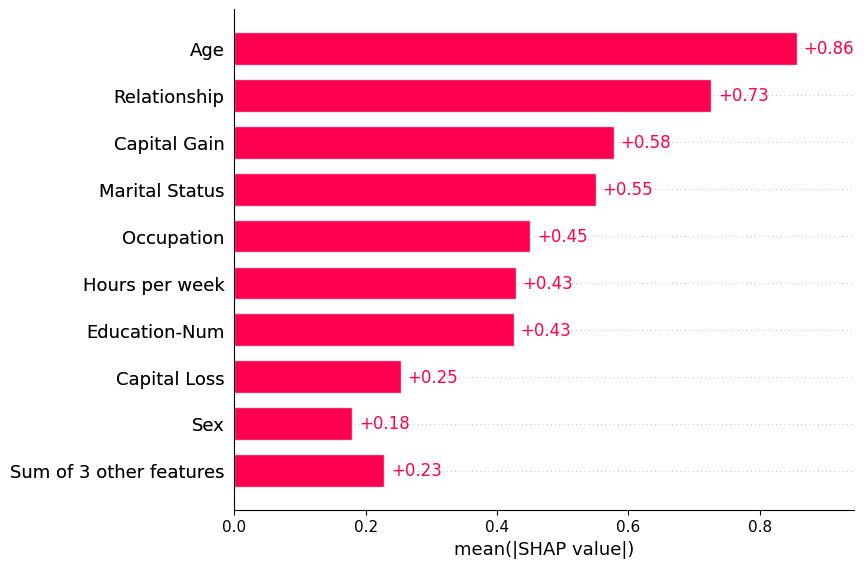

In [6]:
shap.plots.bar(shap_values)

기본적으로 막대형 차트에는 최대 10개의 막대만 표시되지만 `max_display` 매개변수를 사용하여 이를 제어할 수 있습니다:

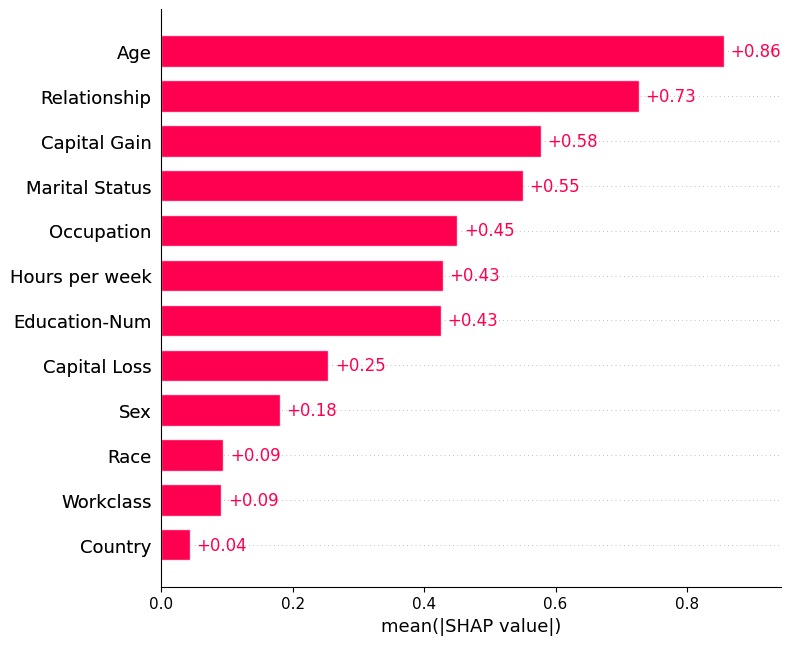

In [7]:
shap.plots.bar(shap_values, max_display=12)

## Local bar 플롯

막대형 막대 그래프 함수에 SHAP 값 행을 전달하면 로컬 특징 중요도 그래프가 생성되며, 여기서 막대는 각 특징의 SHAP 값입니다. 특징 값은 특징 이름 왼쪽에 회색으로 표시됩니다.

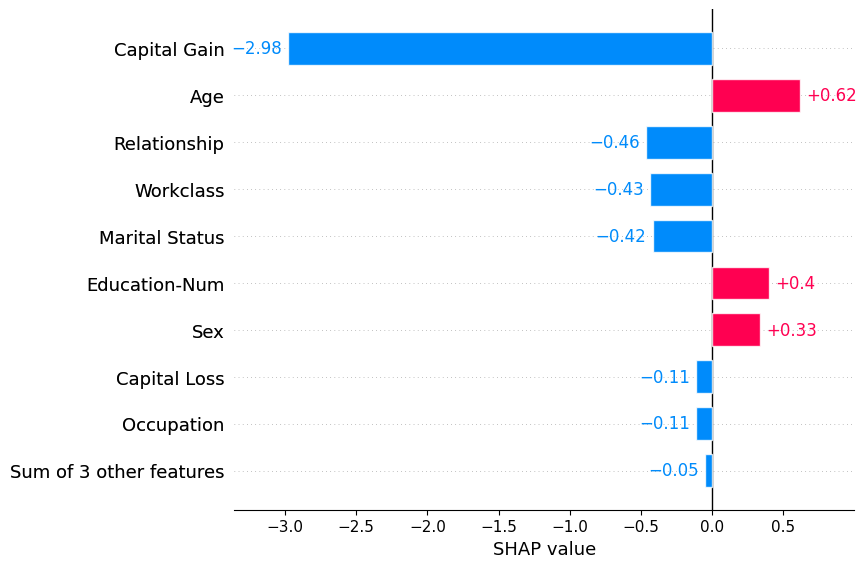

In [8]:
shap.plots.bar(shap_values[0])

## Cohort bar 플롯

설명 개체의 사전을 전달하면 설명 개체가 나타내는 각 코호트에 대해 하나의 막대 유형이 있는 다중 막대 플롯이 만들어집니다. 아래에서는 이를 사용하여 남성과 여성에 대한 특징 중요도의 글로벌 요약을 개별적으로 플롯합니다.

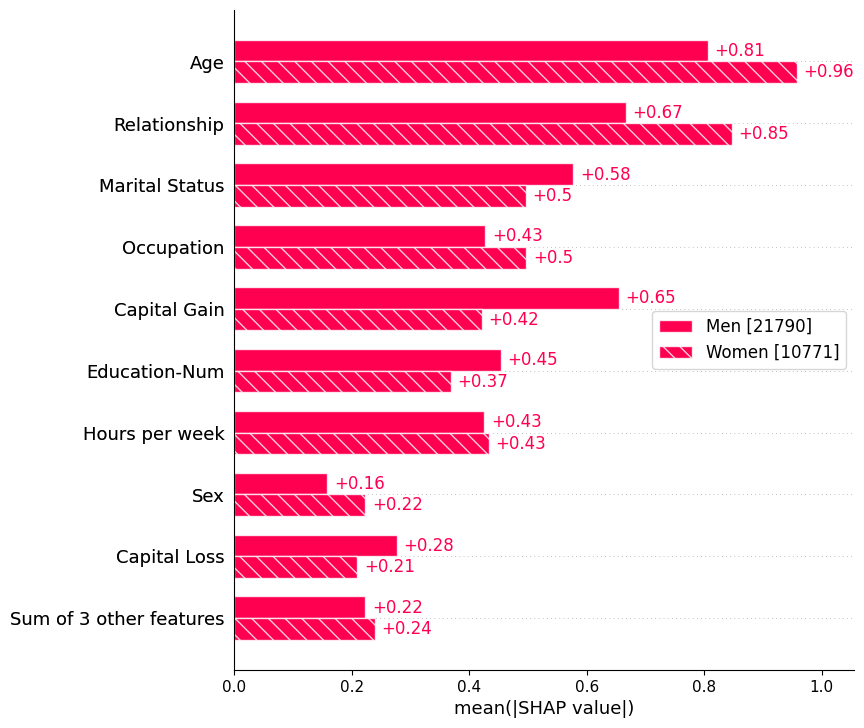

In [9]:
sex = ["Women" if shap_values[i,"Sex"].data == 0 else "Men" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

설명 개체의 자동 코호트 기능을 사용하여 의사 결정 트리를 사용하여 코호트 집합을 만들 수도 있습니다. `Explanation.cohorts(N)`을 호출하면 sklearn DecisionTreeRegressor를 사용하여 인스턴스의 SHAP 값을 최적으로 분리하는 N개의 코호트를 생성합니다. 성인 인구조사 데이터에 대해 이 작업을 수행하면 인구 증가율이 낮은 집단과 높은 집단이 명확하게 구분되는 것을 볼 수 있습니다. 괄호 안의 숫자는 각 코호트의 인스턴스 수입니다.

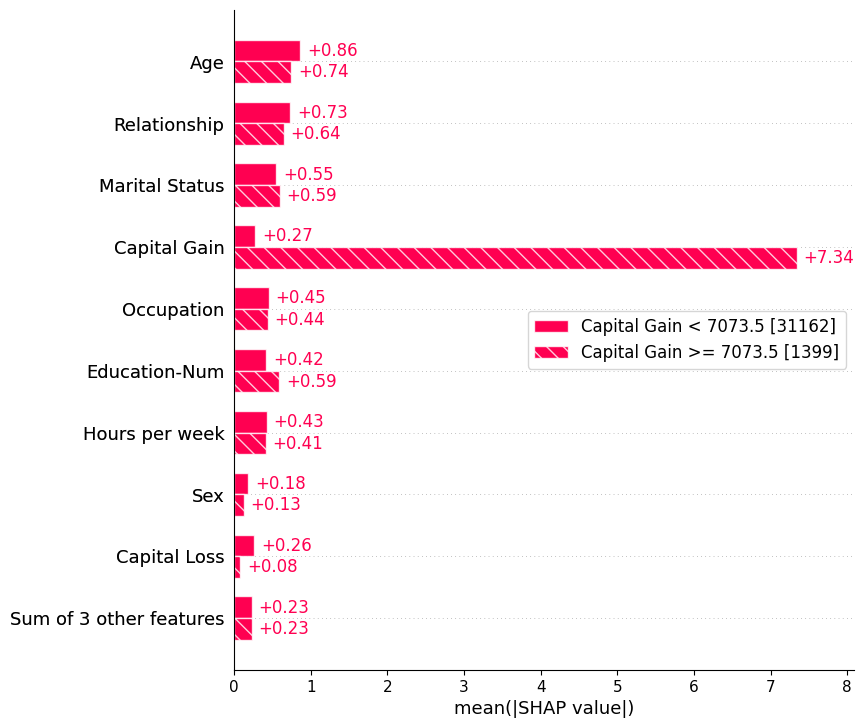

In [10]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

## 특징 클러스터링 사용

데이터 집합의 특징은 서로 부분적으로 또는 완전히 중복되는 경우가 많습니다. 여기서 중복성이란 모델이 두 피처 중 하나를 사용해도 동일한 정확도를 얻을 수 있다는 것을 의미합니다. 이러한 특징을 찾기 위해 실무자는 종종 특징 간의 상관 관계 행렬을 계산하거나 클러스터링 방법을 사용합니다. SHAP으로 작업할 때는 모델 손실 비교를 통해 기능 중복성을 측정하는 보다 직접적인 접근 방식을 권장합니다. `shap.utils.hclust` 메서드를 사용하면 각 입력 특징 쌍에 대한 결과를 예측하기 위해 XGBoost 모델을 훈련하여 특징의 계층적 클러스터링을 구축할 수 있습니다. 일반적인 표 형식 데이터 세트의 경우, 상관 관계와 같은 비지도 방법에서 얻을 수 있는 것보다 훨씬 더 정확한 기능 중복 측정값을 얻을 수 있습니다.

이러한 클러스터링을 계산하고 나면 막대형 차트에 전달하여 특징 중복 구조와 특징 중요도를 동시에 시각화할 수 있습니다. 기본적으로 모든 클러스터링 구조를 표시하지 않고 거리가 0.5 미만인 클러스터링 부분만 표시한다는 점에 유의하세요. 클러스터링의 거리는 대략 0과 1 사이에서 조정된다고 가정하며, 여기서 0은 피처가 완전히 중복되고 1은 완전히 독립적이라는 것을 의미합니다. 아래 플롯에서는 관계 및 결혼 여부만 50% 이상의 중복성을 가지므로 막대형 차트에 그룹화된 유일한 특징임을 알 수 있습니다:

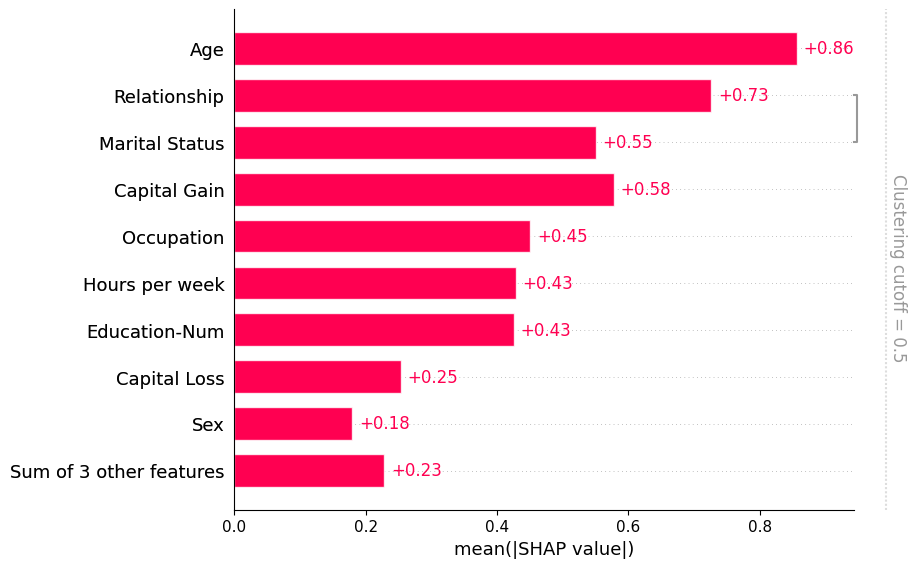

In [14]:
clustering = shap.utils.hclust(X, y) # 기본적으로 이것은 (X.shape[1] 선택 2) 2가지 기능의 XGBoost 모델을 훈련시킵니다.
shap.plots.bar(shap_values, clustering=clustering)

클러스터링 구조를 더 많이 보려면 `clustering_cutoff` 매개변수를 0.5에서 0.9로 조정하면 됩니다. 임계값을 높이면 특징의 순서가 유효한 클러스터 리프 순서를 따르도록 제한된다는 점에 유의하세요. 막대형 막대 그래프는 가장 중요한 피처를 맨 위에 배치하기 위해 각 클러스터와 해당 클러스터의 하위 클러스터 특징 중요도 값을 정렬합니다.

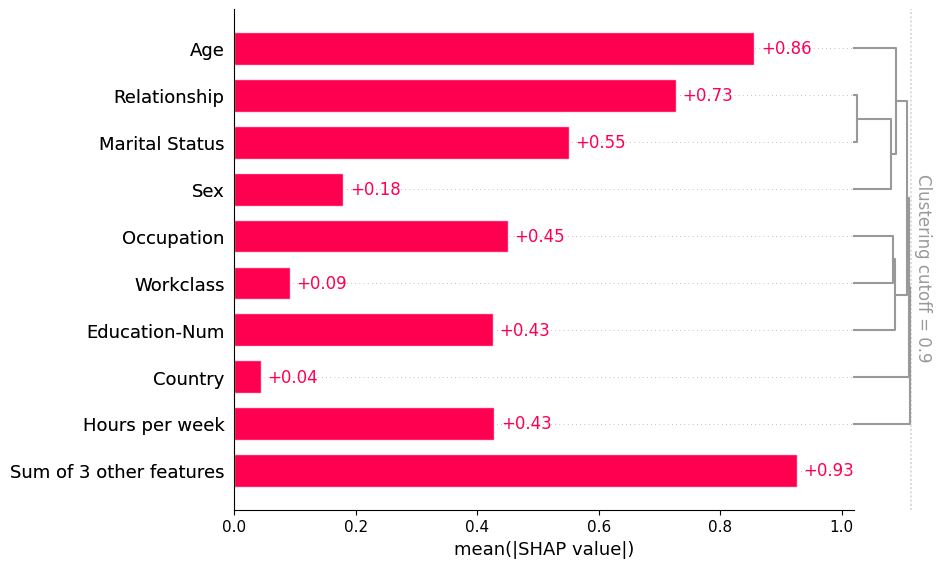

In [18]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.9) 

일부 설명자는 설명 과정에서 클러스터링 구조를 사용하기도 합니다. 이는 모델을 설명하는 동안 비현실적인 방식으로 특징을 교란하는 것을 방지하고 계산 성능을 높이기 위한 것입니다. 이러한 방법을 사용하여 SHAP 설명을 계산하면 설명 개체에 클러스터링이 포함됩니다. 막대형 막대그래프에서 이러한 클러스터링을 발견하면 `clustering` 매개 변수를 명시적으로 전달할 필요 없이 이를 사용합니다:

In [19]:
# 현재 모델에 구애받지 않는 메서드만shap.maskers.TabularPartitions를 지원하므로 모델을 함수로 래핑합니다.
def f(x):
    return model.predict(x, output_margin=True)

# 클러스터링을 사용하는 파티션 마스커를 정의합니다.
masker = shap.maskers.Partition(X, clustering=clustering)

# 모델을 다시 설명합니다.
explainer = shap.Explainer(f, masker)
shap_values_partition = explainer(X[:100])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


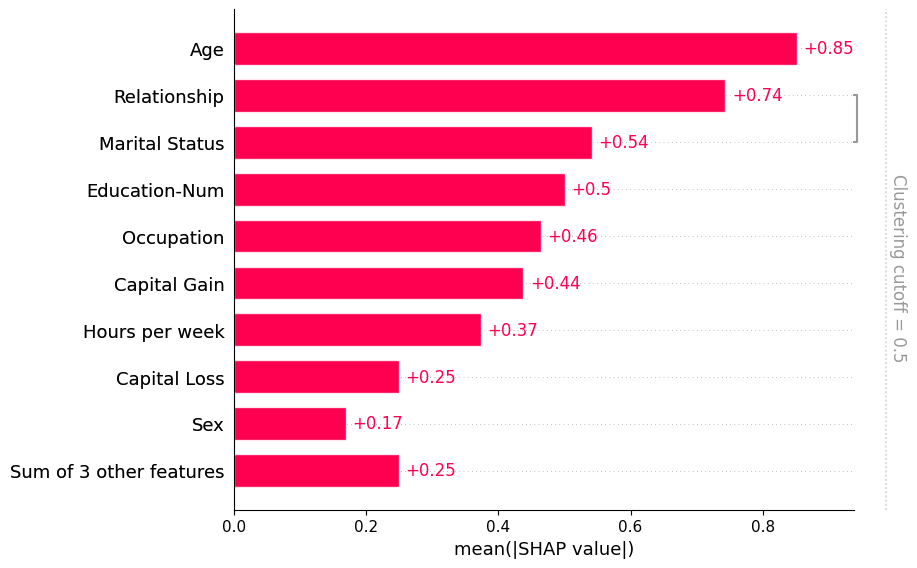

In [20]:
shap.plots.bar(shap_values_partition)

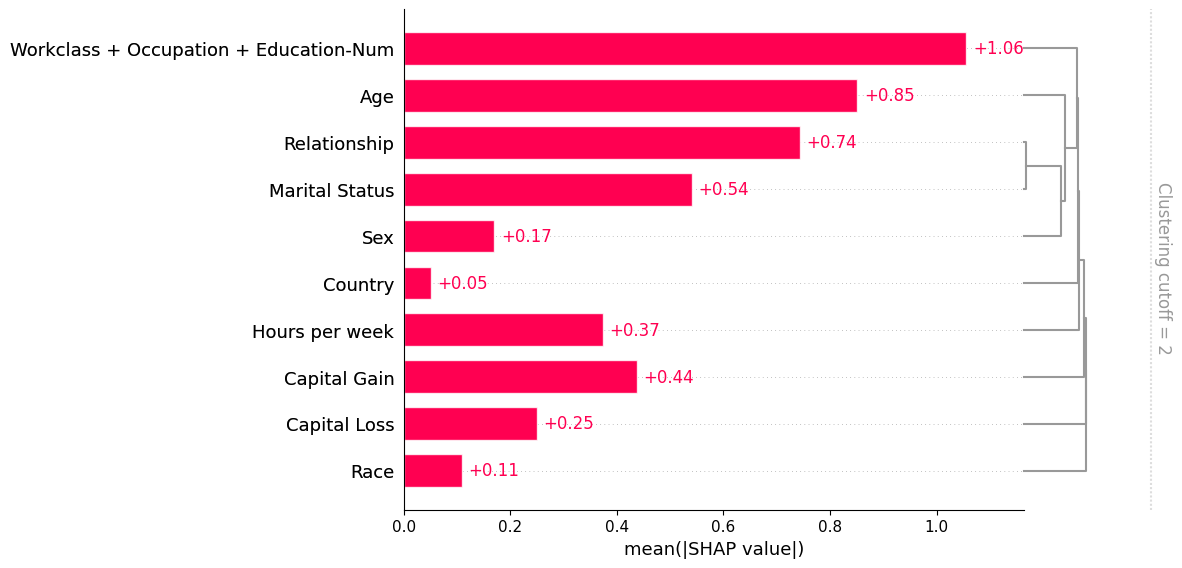

In [22]:
shap.plots.bar(shap_values_partition, clustering_cutoff=2)

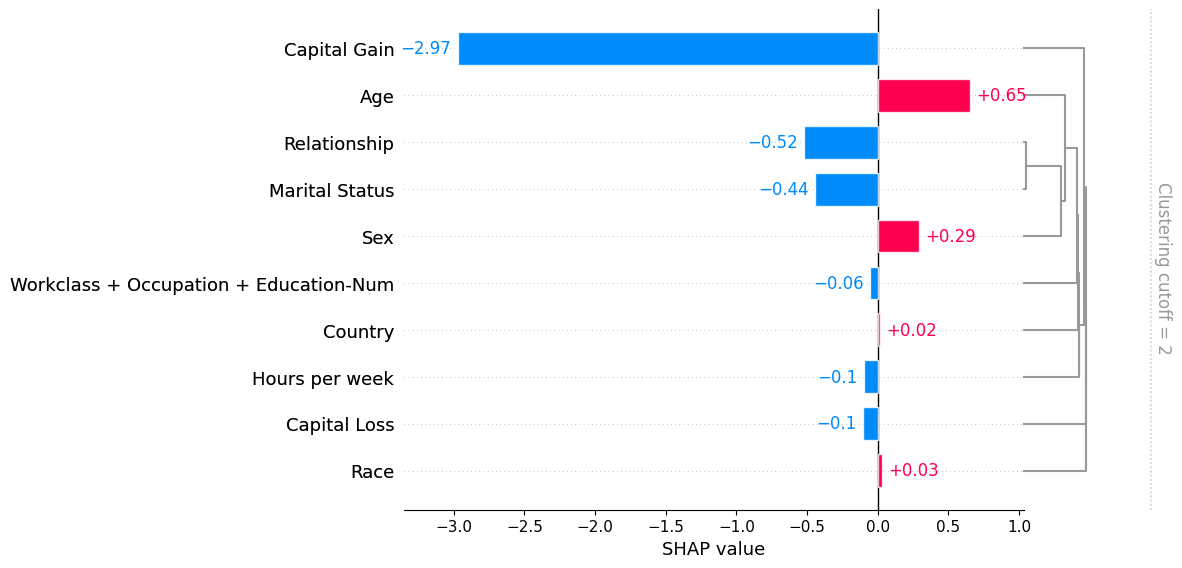

In [23]:
shap.plots.bar(shap_values_partition[0], clustering_cutoff=2)

<hr>
Have an idea for more helpful examples? Pull requests that add to this documentation notebook are encouraged! 